<div style="text-align: center; font-size: 30px">
    Final project: Welcome to Rick and Morty's world!
</div>


Welcome to the final project by Nicola Bagnola and Helle Achari. In this project, we dive into the fascinating world of Rick and Morty to explore the intricate connections between its characters. Who stands out as the most popular? How are they interlinked? Is there an underlying hero vs. villain dynamic? How are the characters described, and what does their sentiment analysis reveal? Can we uncover any intriguing patterns or insights? Using ---OUR METHODS---, we aim to shed light on these questions and uncover fascinating insights about their relationships.

<div style=" font-size: 20px; font-weight: bold;">
    Part 1: The first part of the assignment involves web scraping the required data to enable our analysis.
</div>


First, we import all the necessary packages, including those required for the entire notebook.

In [ ]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy
import networkx as nx
import matplotlib.pyplot as plt 
import json
import os
from urllib.parse import urljoin  

<div style=" font-size: 16px; font-weight: bold;">
    First, we extract the characters information
</div>

In [ ]:
folder_path = "rickmorty_characters"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
# Complete mapped list for the infobox fields
desired_infobox_fields = {
    "SPECIES": "Species",
    "TYPE": "Type",
    "AGE": "Age",
    "AVERAGE LIFESPAN": "Average Lifespan",
    "STATUS": "Status",
    "OCCUPATION": "Occupation",
    "HOME PLANET": "Home Planet",
    "PLACE OF ORIGIN": "Place of Origin",
    "AFFILIATION": "Affiliation",
    "FAMILY": "Family",
    "FIRST APPEARANCE": "First Appearance",
    "FIRST SEEN IN": "First Appearance",
    "VOICE ACTOR": "Voice Actor"
}

# Function to get character links from a given category page URL
def get_character_links(page_url):
    character_links = []
    page = requests.get(page_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Locate all character links on the page
    for link in soup.select(".category-page__member-link"):
        character_url = urljoin("https://rickandmorty.fandom.com", link.get('href'))
        character_links.append(character_url)
    
    # Find the "Next page" link, if it exists
    next_button = soup.select_one(".category-page__pagination-next")
    next_page_url = urljoin("https://rickandmorty.fandom.com", next_button.get('href')) if next_button else None
    
    return character_links, next_page_url

# Function to extract specific infobox data
def extract_infobox_data(soup):
    infobox = soup.find("aside", {"role": "region"})  # Infobox container
    infobox_data = {field_name: None for field_name in set(desired_infobox_fields.values())}  # Initialize with null values

    if infobox:
        for item in infobox.find_all("div", class_="pi-item"):
            label = item.find("h3", class_="pi-data-label")
            value = item.find("div", class_="pi-data-value")
            if label and value:
                label_text = label.get_text(strip=True).upper()  # Convert label to uppercase for matching
                value_text = value.get_text(strip=True)

                # Check if the label_text is in desired_infobox_fields
                if label_text in desired_infobox_fields:
                    mapped_field_name = desired_infobox_fields[label_text]
                    
                    # Handle "First Appearance" by using the first available match between "FIRST APPEARANCE" and "FIRST SEEN IN"
                    if mapped_field_name == "First Appearance" and infobox_data[mapped_field_name] is None:
                        infobox_data[mapped_field_name] = value_text
                    
                    # Handle "Family" and "Affiliation" to ensure multiple entries are separated by commas
                    elif mapped_field_name in ["Family", "Affiliation"]:
                        if infobox_data[mapped_field_name]:
                            infobox_data[mapped_field_name] += ", " + value_text
                        else:
                            infobox_data[mapped_field_name] = value_text
                    else:
                        infobox_data[mapped_field_name] = value_text

    return infobox_data

# Function to scrape character data and save connected URLs
def scrape_character_data(character_url):
    page = requests.get(character_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Retrieve character name
    name = soup.find("h1", class_="page-header__title").text.strip()

    # Extract infobox data
    infobox_data = extract_infobox_data(soup)

    # Locate the main content section (using a div that typically holds character data)
    content_div = soup.find("div", class_="mw-parser-output")
    
    # Collect text content and links
    content_data = []
    page_links = []  # To store URLs linked within the character page

    # Collect all paragraphs and list items, storing text and links
    for element in content_div.find_all(['p', 'ul'], recursive=False):
        if "Fan Feed" in element.text:
            break  # Stop when reaching "Fan Feed"

        item_text = element.get_text(strip=True)
        content_data.append(item_text)

        # Extract and store all internal links in the current element
        for a in element.find_all('a', href=True):
            link_url = urljoin(character_url, a['href'])
            if "rickandmorty.fandom.com/wiki/" in link_url:
                page_links.append(link_url)

    # Structure data for saving
    character_data = {
        "name": name,
        "infobox": infobox_data,  # Add structured infobox data
        "content": "\n".join(content_data),  # Combine all text content into a single field
        "linked_pages": list(set(page_links))  # Store unique URLs to avoid duplicates
    }
    
    # Save each character's data as a JSON file in the specified folder
    filename = f"{folder_path}/{name.replace(' ', '_')}.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(character_data, f, indent=4)
    
    print(f"Saved {name} data to {filename}")
    return character_data

# Main function to iterate through all pages and scrape all characters
def scrape_all_characters(start_url):
    visited_links = set()  # To keep track of already-scraped characters
    current_page = start_url
    
    while current_page:
        print(f"Scraping page: {current_page}")
        character_links, next_page = get_character_links(current_page)
        
        # Scrape each character on the current page
        for link in character_links:
            if link in visited_links:  # Skip if already scraped
                print(f"Skipping already scraped character: {link}")
                continue
            
            try:
                scrape_character_data(link)  # Save data immediately for each character
                visited_links.add(link)  # Mark as visited
                time.sleep(1)  # Respectful delay
            except Exception as e:
                print(f"Failed to scrape {link}: {e}")
        
        # Move to the next page
        current_page = next_page

# Start URL for the character category
start_url = "https://rickandmorty.fandom.com/wiki/Category:Characters"
scrape_all_characters(start_url)


<div style=" font-size: 20px; font-weight: bold;">
    Part 2: Part 2 will focus on building the network giving the webscrabed data and analyzing the network
</div>


After downloading the Wikipedia pages containing character descriptions, we now prepare to construct a network.

Network saved as 'rickmorty_character_network.pkl'.
Number of nodes (characters): 698
Number of edges (connections): 2262


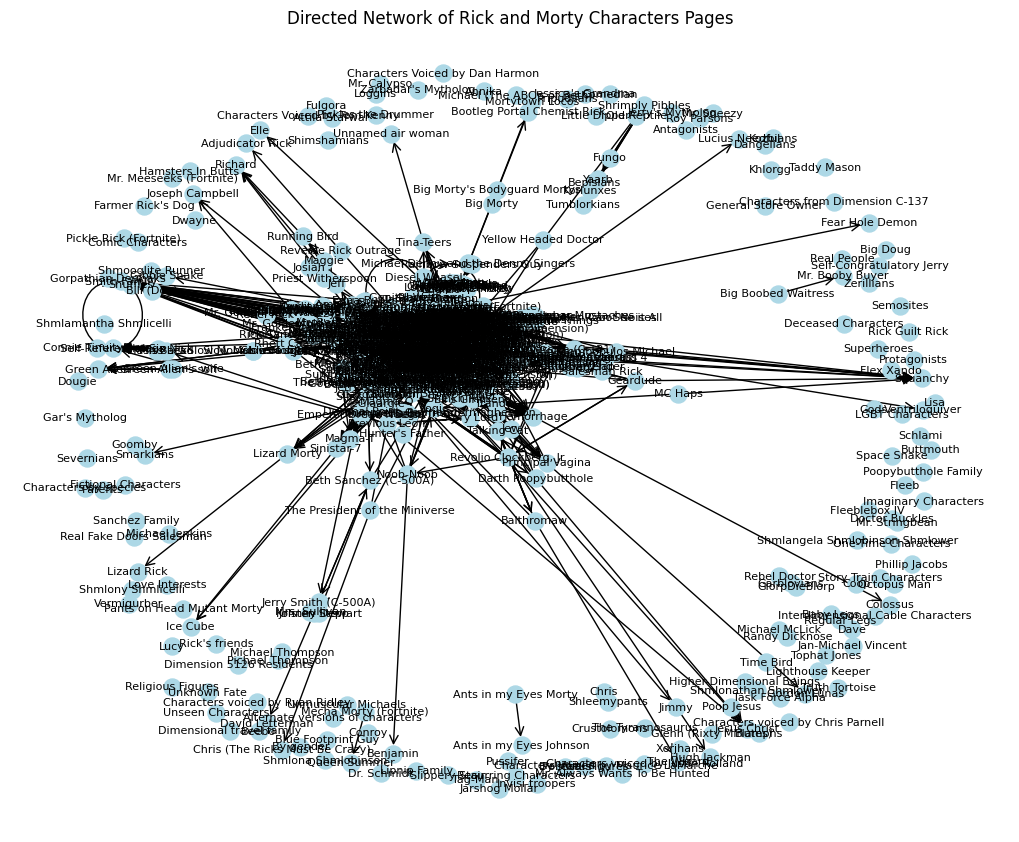

In [ ]:
# Path to the folder containing character JSON files
character_folder = "rickmorty_characters"

# Base URL of the Fandom wiki for comparison
base_url = "https://rickandmorty.fandom.com/wiki/"

# Step 1: Parse all character files
character_files = [f for f in os.listdir(character_folder) if f.endswith('.json')]
character_names = set()
character_links = {}

for file in character_files:
    with open(os.path.join(character_folder, file), 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Store character name
        character_names.add(data['name'])
        # Map character to their valid links
        character_links[data['name']] = data['linked_pages']

# Step 2: Filter valid links (only keep links to other characters)
filtered_links = {}
for character, links in character_links.items():
    valid_links = [link for link in links if os.path.basename(link) in {f.split('.json')[0] for f in character_files}]
    filtered_links[character] = valid_links

# Step 3: Build the network
G = nx.DiGraph()  # Directed graph since links have direction

# Add nodes and edges
for character, links in filtered_links.items():
    G.add_node(character)  # Add character as a node
    for link in links:
        linked_character = os.path.basename(link).replace('_', ' ')  # Convert link to character name
        if linked_character in character_names:
            G.add_edge(character, linked_character)  # Add edge if the linked character is valid

print(f"Number of nodes (characters): {G.number_of_nodes()}")
print(f"Number of edges (connections): {G.number_of_edges()}")

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    node_size=150,
    font_color="black",
    arrowstyle='->',
    arrows=True,
    arrowsize=15
)
plt.title("Directed Network of Rick and Morty Characters Pages")
plt.show()


The visualized directed network represents the relationships between characters from the Rick and Morty universe based on data extracted from their respective Wikipedia pages. Each node represents a character, while each directed edge indicates a connection, most likely as mentions. The network contains 698 nodes (characters) and 2262 edges (connections). 

The network above does not filter out nodes with zero connections. While the number of edges remains unchanged, let us examine how many nodes are removed from the network.

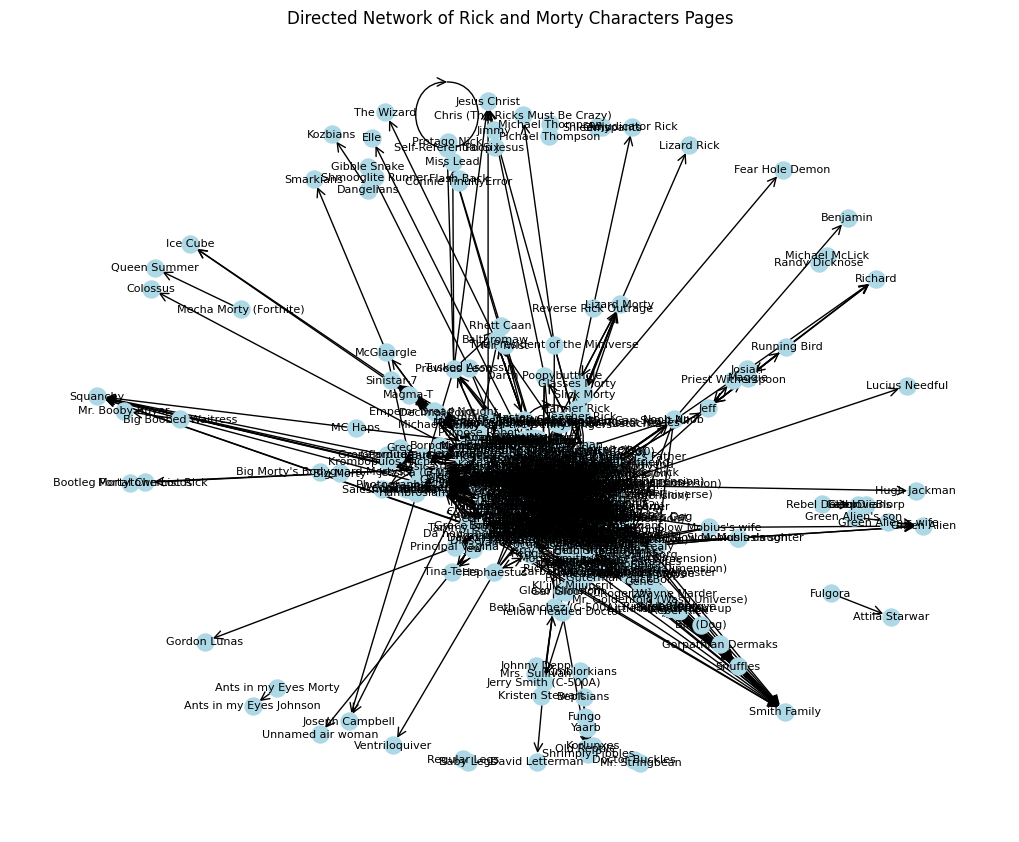

Number of nodes (characters): 586
Number of edges (connections): 2262
Network saved as 'rickmorty_character_network.pkl'.


In [10]:
zero_degree_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(zero_degree_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    font_size=8,
    node_size=150,
    font_color="black",
    arrowstyle='->',
    arrows=True,
    arrowsize=15
)
plt.title("Directed Network of Rick and Morty Characters Pages")
plt.show()

print(f"Number of nodes (characters): {G.number_of_nodes()}")
print(f"Number of edges (connections): {G.number_of_edges()}")

with open("rickmorty_character_network.pkl", "wb") as f:
    pickle.dump(G, f)

# Print some basic network stats
print(f"Network saved as 'rickmorty_character_network.pkl'.")

Approximately one hundred nodes have been removed from the network. This refined network will be the one we work with moving forward. 

Now for inspecting the network a bit more by finding the biggest component. 

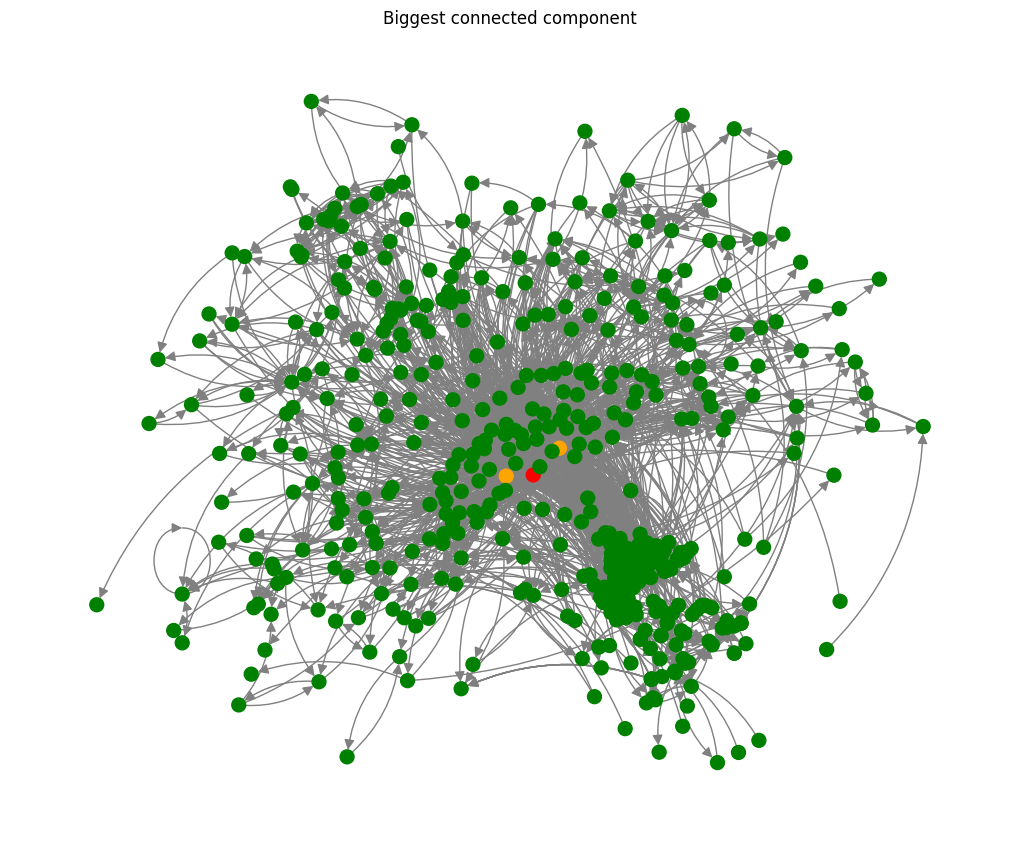

Number of nodes in the graph: 563
Number of edges in the graph: 2245


In [48]:
with open("rickmorty_character_network.pkl", "rb") as f:
    G = pickle.load(f)
    
components = nx.weakly_connected_components(G) # we use weakly connected components as the graph is directed
components_ordered = sorted(components, key=len, reverse=True)
biggest_component = components_ordered[0]

G_biggest_component = G.subgraph(biggest_component).copy()

node_degrees = dict(G_biggest_component.degree())
node_colors = [
    "green" if node_degrees[node] <= 100 else
    "orange" if 100 < node_degrees[node] <= 300 else
    "red" for node in G_biggest_component.nodes()
]

plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G_biggest_component)

nx.draw(
    G_biggest_component,
    pos,
    with_labels=False,
    node_color=node_colors,
    font_size=8,
    node_size = 100,
    font_color="black",
    edge_color="gray",
    arrowstyle='-|>',
    arrows=True,
    arrowsize=15,
    connectionstyle="arc3,rad=0.2"
)
plt.title("Biggest connected component")
plt.show()

print(f"Number of nodes in the graph: {G_biggest_component.number_of_nodes()}")
print(f"Number of edges in the graph: {G_biggest_component.number_of_edges()}")

The biggest component almost makes up the whole network, which means that the network is highly interconnected. Most nodes are part of a single, large cluster, indicating that the majority of characters are directly or indirectly linked to each other. This suggests a cohesive structure where relationships between characters play a central role in the overall network dynamics.

Delving deeper into the analysis of the largest component, let's examine the in-degree and out-degree of its nodes.

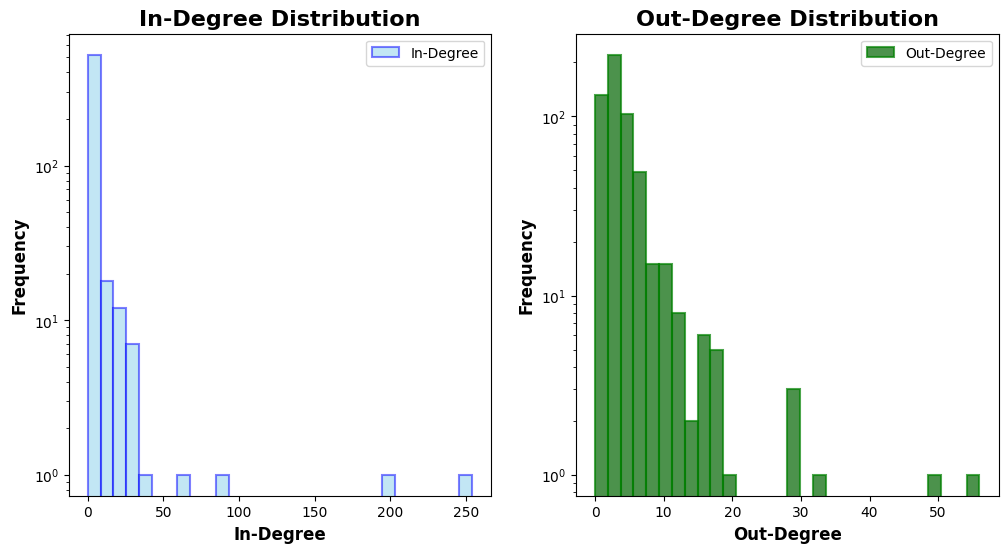

In [50]:
in_degrees = [d for _, d in G_biggest_component.in_degree()]
out_degrees = [d for _, d in G_biggest_component.out_degree()]

# Plot in-degree distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=30, alpha=0.5, edgecolor='Blue', color = "skyblue", linewidth=1.5, label="In-Degree", log=True)
plt.xlabel('In-Degree', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='black')
plt.title("In-Degree Distribution", fontsize=16, fontweight='bold', color='black')
plt.legend()

# Plot out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=30, alpha=0.7, edgecolor='Green', color = "darkgreen", linewidth=1.5, label="Out-Degree", log=True)
plt.xlabel('Out-Degree', fontsize=12, fontweight='bold', color='black')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='black')
plt.title("Out-Degree Distribution", fontsize=16, fontweight='bold', color='black')
plt.legend()
plt.show()

TO BE ANSWERED: What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

It could be find to find the node with the highest in and out degree versus the node with lowest. 

In [49]:
# Get the top 3 nodes with the highest in-degree
top_3_in_degrees = sorted(G_biggest_component.in_degree(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 nodes with the highest in-degree:")
for node, degree in top_3_in_degrees:
    print(f"{node} (In-Degree: {degree})")

# Get the top 3 nodes with the highest out-degree
top_3_out_degrees = sorted(G_biggest_component.out_degree(), key=lambda x: x[1], reverse=True)[:3]
print("\nTop 3 nodes with the highest out-degree:")
for node, degree in top_3_out_degrees:
    print(f"{node} (Out-Degree: {degree})")


Top 3 nodes with the highest in-degree:
Rick Sanchez (In-Degree: 254)
Morty Smith (In-Degree: 197)
Summer Smith (In-Degree: 91)

Top 3 nodes with the highest out-degree:
Rick Sanchez (Out-Degree: 56)
Morty Smith (Out-Degree: 49)
Beth Smith (Out-Degree: 32)
